In [8]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Load data
df = pd.read_csv("../results/city_budget_system_frame_partner_all_results.csv")

# Compute allocation proportions
df['partner_alloc'] = df['alloc1'] / (df['alloc0'] + df['alloc1'])
df['self_alloc'] = df['alloc0'] / (df['alloc0'] + df['alloc1'])

# Extract experimental conditions
df['cot'] = df['experiment_id'].str.contains('fiscal_cot')
df['framing'] = df['experiment_id'].str.extract('(give|take|divide)')[0]
df['partner'] = df['experiment_id'].str.extract('(housing|council|nimby)')[0]

# Quick look at the data
print("Dataset shape:", df.shape)
print("\nSample allocations:")
print(df[['model', 'self_alloc', 'partner_alloc', 'framing', 'partner', 'cot']].head())

Dataset shape: (1440, 15)

Sample allocations:
                       model  self_alloc  partner_alloc framing  partner  \
0  claude-3-5-haiku-20241022        0.30           0.70    give  housing   
1  claude-3-5-haiku-20241022        0.20           0.80    give  housing   
2  claude-3-5-haiku-20241022        0.25           0.75    give  housing   
3  claude-3-5-haiku-20241022        0.50           0.50    give  housing   
4  claude-3-5-haiku-20241022        0.50           0.50    give  housing   

     cot  
0  False  
1  False  
2  False  
3  False  
4  False  


In [10]:
# Helper function for statistical tests
def analyze_groups(group1, group2, label1, label2):
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Effect size (Cohen's d)
    d = (np.mean(group1) - np.mean(group2)) / np.sqrt(
        ((len(group1) - 1) * np.var(group1) + 
         (len(group2) - 1) * np.var(group2)) / 
        (len(group1) + len(group2) - 2)
    )
    
    # Interpret effect size
    if abs(d) < 0.2:
        effect = "negligible"
    elif abs(d) < 0.5:
        effect = "small"
    elif abs(d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"\n{label1} (n={len(group1)}) vs {label2} (n={len(group2)}):")
    print(f"  Partner allocation: {np.mean(group1)*100:.1f}% vs {np.mean(group2)*100:.1f}%")
    print(f"  Difference: {(np.mean(group1) - np.mean(group2))*100:.1f}% points")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Effect size: {abs(d):.3f} ({effect})")

In [12]:
# Analyze model differences
print("=== Model Comparisons ===")
models = df['model'].unique()

for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        group1 = df[df['model'] == model1]['partner_alloc']
        group2 = df[df['model'] == model2]['partner_alloc']
        analyze_groups(group1, group2, model1, model2)

=== Model Comparisons ===

claude-3-5-haiku-20241022 (n=360) vs claude-3-5-sonnet-20241022 (n=360):
  Partner allocation: 43.2% vs 77.8%
  Difference: -34.7% points
  p-value: nan
  Effect size: 1.297 (large)

claude-3-5-haiku-20241022 (n=360) vs claude-3-haiku-20240307 (n=360):
  Partner allocation: 43.2% vs 42.4%
  Difference: 0.8% points
  p-value: 0.338536
  Effect size: 0.037 (negligible)

claude-3-5-haiku-20241022 (n=360) vs claude-3-opus-20240229 (n=360):
  Partner allocation: 43.2% vs 80.8%
  Difference: -37.7% points
  p-value: nan
  Effect size: 1.370 (large)

claude-3-5-sonnet-20241022 (n=360) vs claude-3-haiku-20240307 (n=360):
  Partner allocation: 77.8% vs 42.4%
  Difference: 35.4% points
  p-value: nan
  Effect size: 1.488 (large)

claude-3-5-sonnet-20241022 (n=360) vs claude-3-opus-20240229 (n=360):
  Partner allocation: 77.8% vs 80.8%
  Difference: -3.0% points
  p-value: nan
  Effect size: 0.100 (negligible)

claude-3-haiku-20240307 (n=360) vs claude-3-opus-20240229 (

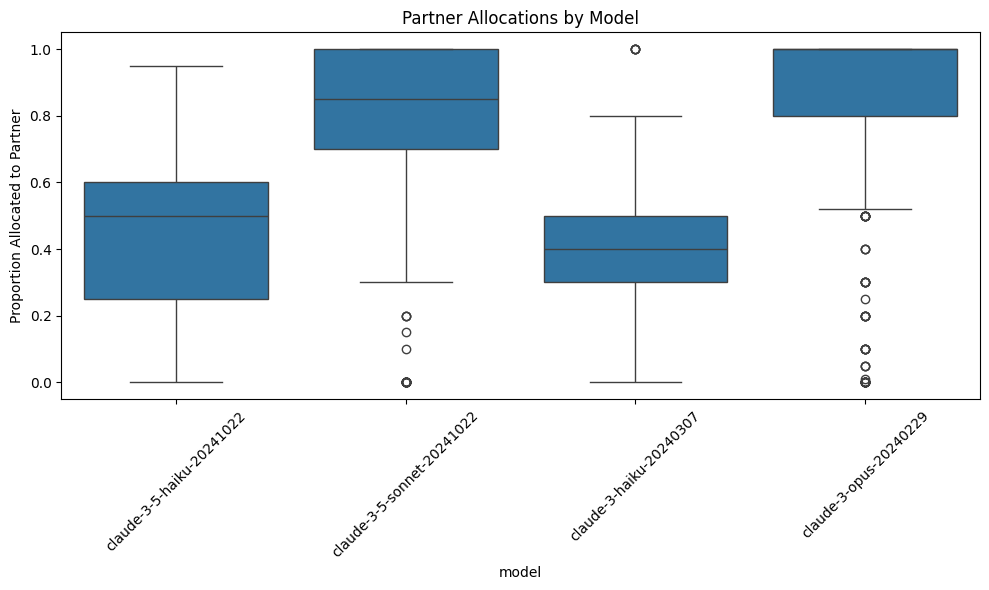

In [14]:
# Visualize model differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='model', y='partner_alloc')
plt.title('Partner Allocations by Model')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== CoT vs NoCoT ===

CoT (n=720) vs NoCoT (n=720):
  Partner allocation: 60.3% vs 61.7%
  Difference: -1.4% points
  p-value: nan
  Effect size: 0.045 (negligible)


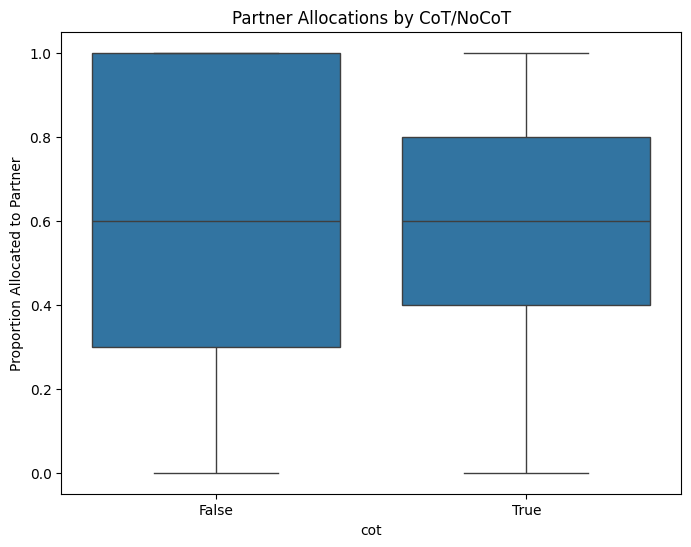

In [15]:
# Analyze CoT differences
print("=== CoT vs NoCoT ===")
cot_group = df[df['cot']]['partner_alloc']
nocot_group = df[~df['cot']]['partner_alloc']
analyze_groups(cot_group, nocot_group, 'CoT', 'NoCoT')

# Visualize CoT differences
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cot', y='partner_alloc')
plt.title('Partner Allocations by CoT/NoCoT')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

=== Framing Comparisons ===

give (n=480) vs take (n=480):
  Partner allocation: 48.9% vs 73.2%
  Difference: -24.3% points
  p-value: 0.000000
  Effect size: 0.791 (medium)

give (n=480) vs divide (n=480):
  Partner allocation: 48.9% vs 60.9%
  Difference: -12.0% points
  p-value: nan
  Effect size: 0.384 (small)

take (n=480) vs divide (n=480):
  Partner allocation: 73.2% vs 60.9%
  Difference: 12.3% points
  p-value: nan
  Effect size: 0.441 (small)


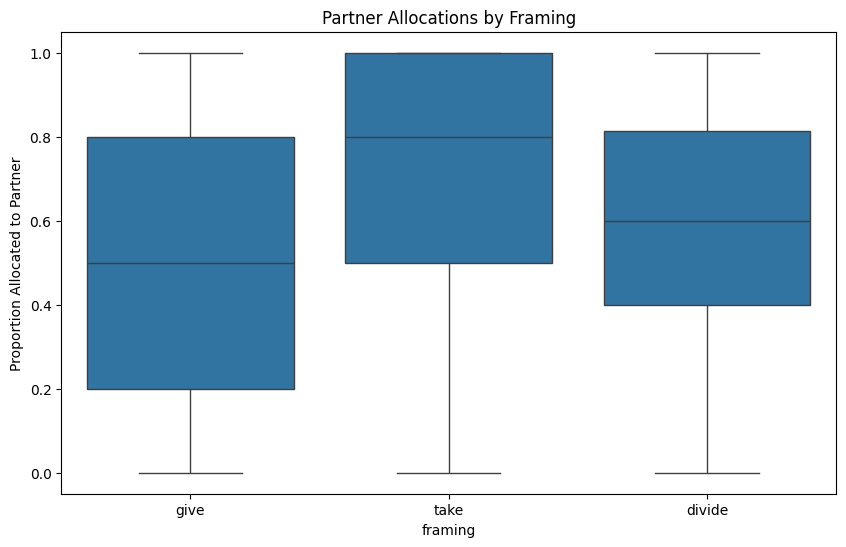

In [17]:
# Analyze framing differences
print("=== Framing Comparisons ===")
framings = df['framing'].unique()

for i, frame1 in enumerate(framings):
    for frame2 in framings[i+1:]:
        group1 = df[df['framing'] == frame1]['partner_alloc']
        group2 = df[df['framing'] == frame2]['partner_alloc']
        analyze_groups(group1, group2, frame1, frame2)

# Visualize framing differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='framing', y='partner_alloc')
plt.title('Partner Allocations by Framing')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

=== Partner Comparisons ===

housing (n=480) vs council (n=480):
  Partner allocation: 72.3% vs 61.6%
  Difference: 10.7% points
  p-value: 0.000000
  Effect size: 0.410 (small)

housing (n=480) vs nimby (n=480):
  Partner allocation: 72.3% vs 49.1%
  Difference: 23.1% points
  p-value: nan
  Effect size: 0.751 (medium)

council (n=480) vs nimby (n=480):
  Partner allocation: 61.6% vs 49.1%
  Difference: 12.5% points
  p-value: nan
  Effect size: 0.377 (small)


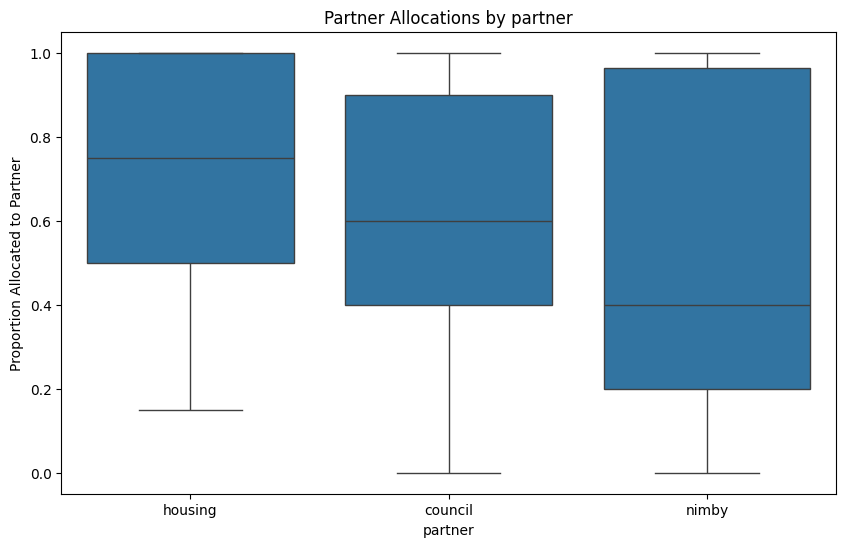

In [18]:
# Analyze partner differences
print("=== Partner Comparisons ===")
partners = df['partner'].unique()

for i, partner1 in enumerate(partners):
    for partner2 in partners[i+1:]:
        group1 = df[df['partner'] == partner1]['partner_alloc']
        group2 = df[df['partner'] == partner2]['partner_alloc']
        analyze_groups(group1, group2, partner1, partner2)

# Visualize partner differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='partner', y='partner_alloc')
plt.title('Partner Allocations by partner')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

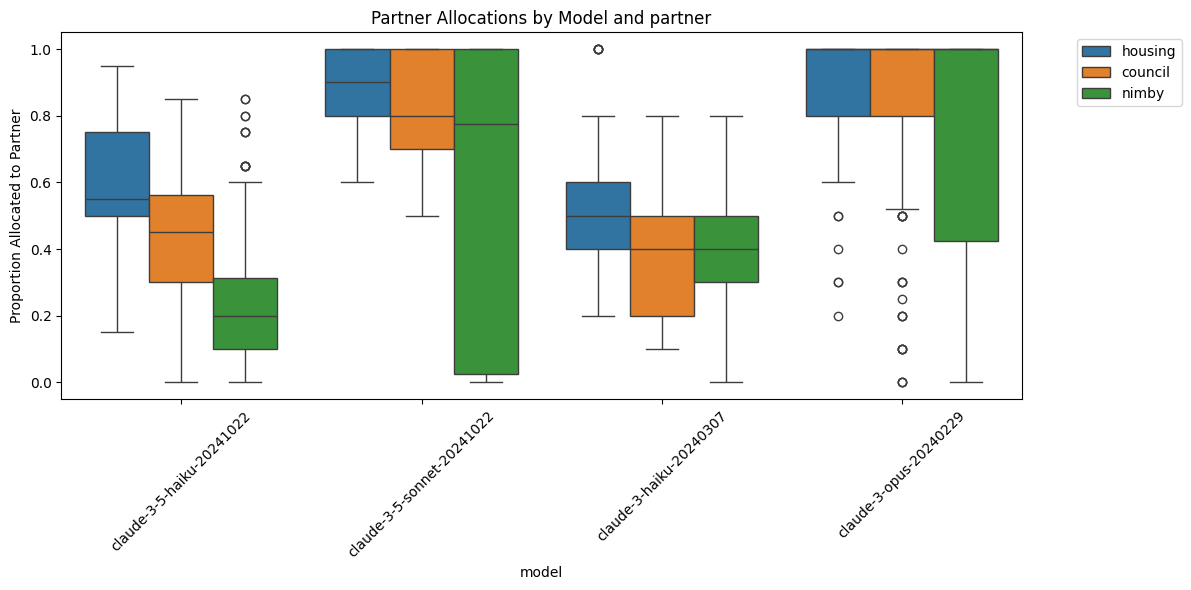

In [20]:
# Look at model-partner interactions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model', y='partner_alloc', hue='partner')
plt.title('Partner Allocations by Model and partner')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

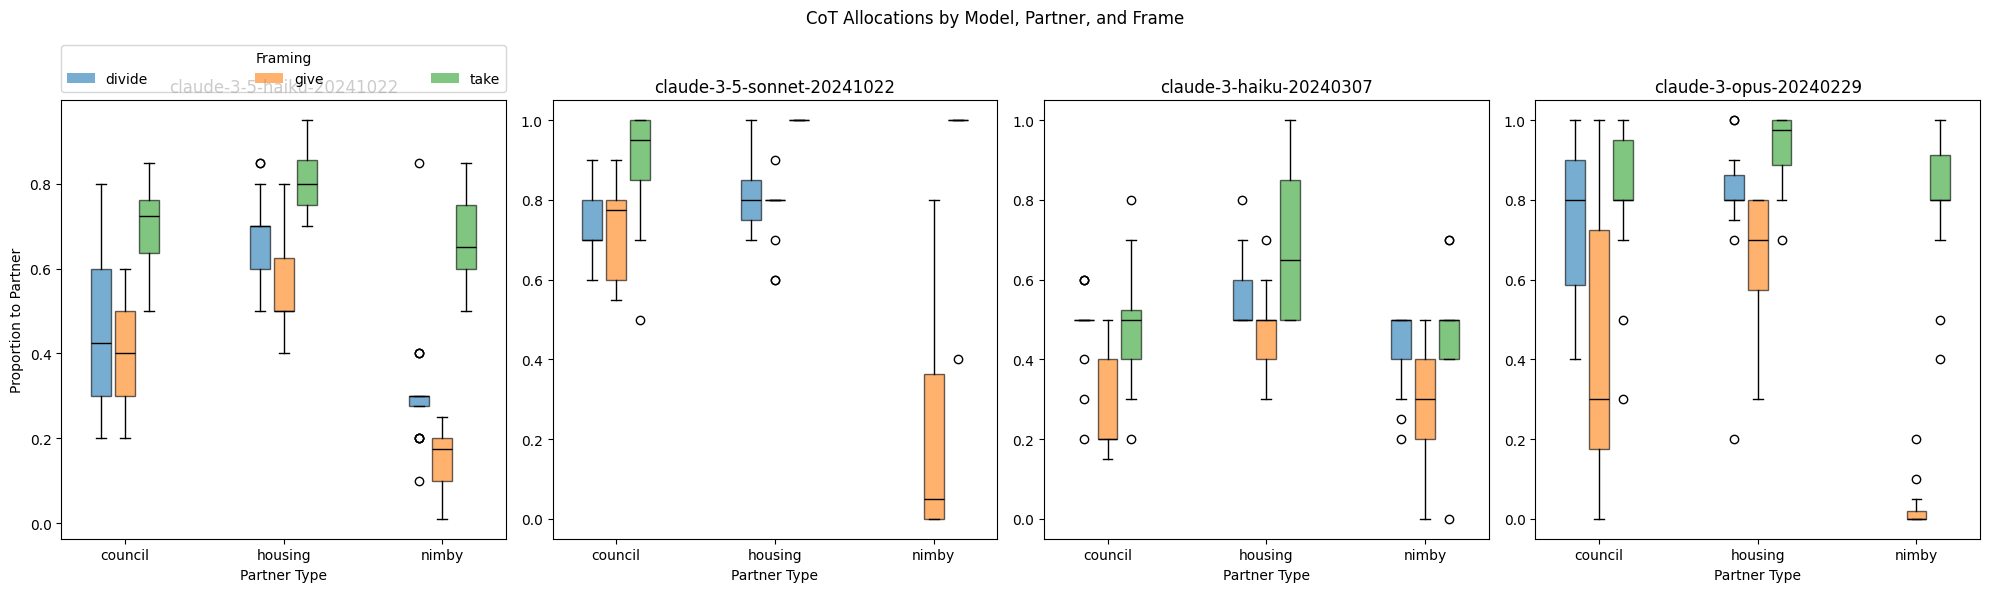

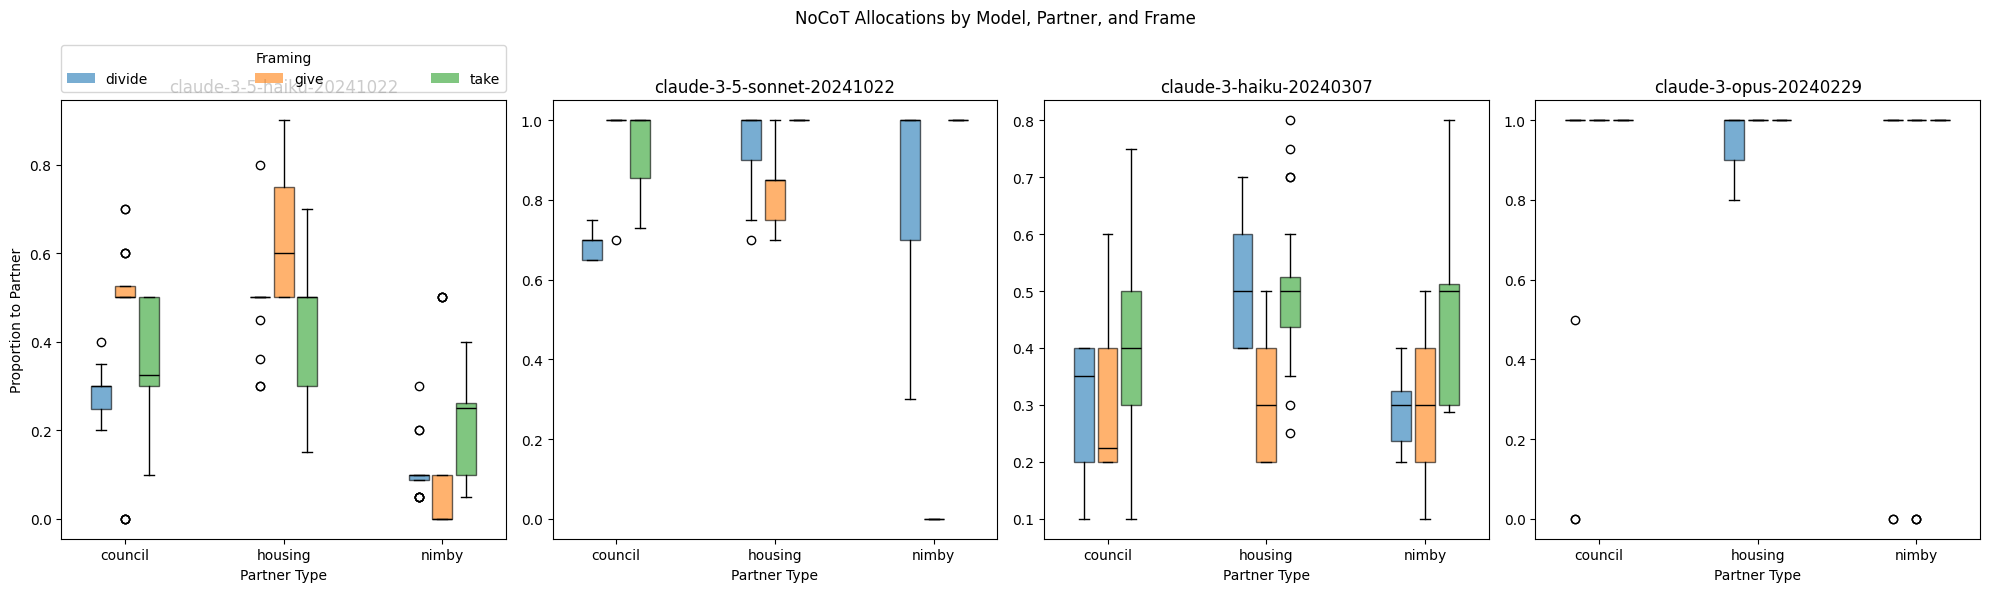

In [28]:
# Create multi-factor visualization for CoT and NoCoT separately
models = sorted(df['model'].unique())
partners = sorted(df['partner'].unique())
frames = sorted(df['framing'].unique())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Fixed colors for frames

for is_cot in [True, False]:
    # Create a subplot for each model
    fig, axs = plt.subplots(1, len(models), figsize=(20, 6))
    fig.suptitle(f"{'CoT' if is_cot else 'NoCoT'} Allocations by Model, Partner, and Frame")
    
    # Filter data for CoT/NoCoT
    plot_data = df[df['cot'] == is_cot]
    
    # For each model (subplot)
    for model_idx, model in enumerate(models):
        ax = axs[model_idx]
        model_data = plot_data[plot_data['model'] == model]
        
        # Prepare data for grouped boxplot
        positions = []
        data_points = []
        colors_map = []
        
        # For each partner
        for partner_idx, partner in enumerate(partners):
            # For each frame
            for frame_idx, frame in enumerate(frames):
                mask = (model_data['partner'] == partner) & (model_data['framing'] == frame)
                data_points.append(model_data[mask]['partner_alloc'])
                # Reduced spacing between groups (changed from 4 to 2)
                positions.append(partner_idx * 2 + frame_idx * 0.3)  # Reduced frame spacing
                colors_map.append(colors[frame_idx])
        
        # Create boxplots with consistent black lines
        bplots = ax.boxplot(data_points, positions=positions, patch_artist=True,
                          medianprops=dict(color='black'),
                          whiskerprops=dict(color='black'),
                          capprops=dict(color='black'),
                          flierprops=dict(color='black', markeredgecolor='black'),
                          widths=0.25)  # Reduced width of boxes
        
        # Color the boxes according to frame
        for patch, color in zip(bplots['boxes'], colors_map):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        # Customize plot
        ax.set_title(model)
        ax.set_ylabel('Proportion to Partner' if model_idx == 0 else '')
        # Adjusted x-tick positions
        ax.set_xticks([p * 2 + 0.3 for p in range(len(partners))])
        ax.set_xticklabels(partners)
        ax.set_xlabel('Partner Type')
        
        # Add legend only to first subplot, above the plot
        if model_idx == 0:
            handles = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.6) for color in colors]
            ax.legend(handles, frames, title='Framing', 
                     bbox_to_anchor=(0, 1.02, 1, 0.2), 
                     loc="lower left",
                     mode="expand",
                     borderaxespad=0,
                     ncol=len(frames))
    
    plt.tight_layout()
    plt.show()

In [24]:
# Create summary statistics for all subgroups
summary_stats = df.groupby(['cot', 'partner', 'framing', 'model'])['partner_alloc'].agg([
    'count',
    'mean',
    'std'
]).reset_index()

# Add 95% confidence intervals
summary_stats['ci'] = 1.96 * summary_stats['std'] / np.sqrt(summary_stats['count'])

# Print summary for each CoT condition
for is_cot in [True, False]:
    print(f"\n{'='*20} {'CoT' if is_cot else 'NoCoT'} {'='*20}")
    cot_stats = summary_stats[summary_stats['cot'] == is_cot].sort_values(
        ['partner', 'framing', 'model']
    )
    
    # Format for printing
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print(cot_stats.to_string(index=False))


==================== CoT ====================
 cot partner framing                      model  count  mean   std    ci
True council  divide  claude-3-5-haiku-20241022     20 0.455 0.160 0.070
True council  divide claude-3-5-sonnet-20241022     20 0.738 0.083 0.036
True council  divide    claude-3-haiku-20240307     20 0.485 0.093 0.041
True council  divide     claude-3-opus-20240229     20 0.763 0.191 0.084
True council    give  claude-3-5-haiku-20241022     20 0.408 0.105 0.046
True council    give claude-3-5-sonnet-20241022     20 0.728 0.119 0.052
True council    give    claude-3-haiku-20240307     20 0.297 0.124 0.054
True council    give     claude-3-opus-20240229     20 0.438 0.330 0.144
True council    take  claude-3-5-haiku-20241022     20 0.703 0.106 0.046
True council    take claude-3-5-sonnet-20241022     20 0.897 0.134 0.059
True council    take    claude-3-haiku-20240307     20 0.495 0.132 0.058
True council    take     claude-3-opus-20240229     20 0.820 0.176 0.077
True

In [25]:
# Let's also look at the most extreme differences between subgroups
def get_subgroup_allocs(data, partner, frame, model):
    mask = (
        (data['partner'] == partner) & 
        (data['framing'] == frame) & 
        (data['model'] == model)
    )
    return data[mask]['partner_alloc']

# Compare all subgroup pairs within each CoT condition
for is_cot in [True, False]:
    print(f"\n{'='*20} {'CoT' if is_cot else 'NoCoT'} {'='*20}")
    data = df[df['cot'] == is_cot]
    
    partners = data['partner'].unique()
    frames = data['framing'].unique()
    models = data['model'].unique()
    
    # Find most extreme differences
    comparisons = []
    for p1 in partners:
        for f1 in frames:
            for m1 in models:
                group1 = get_subgroup_allocs(data, p1, f1, m1)
                if len(group1) == 0:
                    continue
                    
                for p2 in partners:
                    for f2 in frames:
                        for m2 in models:
                            if p1 == p2 and f1 == f2 and m1 == m2:
                                continue
                                
                            group2 = get_subgroup_allocs(data, p2, f2, m2)
                            if len(group2) == 0:
                                continue
                                
                            diff = np.mean(group1) - np.mean(group2)
                            comparisons.append({
                                'group1': f"{p1}-{f1}-{m1}",
                                'group2': f"{p2}-{f2}-{m2}",
                                'diff': diff,
                                'mean1': np.mean(group1),
                                'mean2': np.mean(group2)
                            })
    
    # Sort by absolute difference and show top 5
    comparisons.sort(key=lambda x: abs(x['diff']), reverse=True)
    print("\nLargest differences between subgroups:")
    for i, comp in enumerate(comparisons[:5], 1):
        print(f"\n{i}. {comp['group1']} vs {comp['group2']}")
        print(f"   {comp['mean1']*100:.1f}% vs {comp['mean2']*100:.1f}%")
        print(f"   Difference: {comp['diff']*100:.1f}% points")


==================== CoT ====================

Largest differences between subgroups:

1. housing-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-opus-20240229
   100.0% vs 2.3%
   Difference: 97.7% points

2. nimby-give-claude-3-opus-20240229 vs housing-take-claude-3-5-sonnet-20241022
   2.3% vs 100.0%
   Difference: -97.7% points

3. nimby-give-claude-3-opus-20240229 vs nimby-take-claude-3-5-sonnet-20241022
   2.3% vs 97.0%
   Difference: -94.7% points

4. nimby-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-opus-20240229
   97.0% vs 2.3%
   Difference: 94.7% points

5. housing-take-claude-3-opus-20240229 vs nimby-give-claude-3-opus-20240229
   92.5% vs 2.3%
   Difference: 90.2% points

==================== NoCoT ====================

Largest differences between subgroups:

1. housing-give-claude-3-opus-20240229 vs nimby-give-claude-3-5-sonnet-20241022
   100.0% vs 0.0%
   Difference: 100.0% points

2. housing-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-5-s